In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

In [2]:
import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    Pad,
    SpatialPad,
)

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()
torch.cuda.empty_cache()

MONAI version: 1.2.0
Numpy version: 1.24.3
Pytorch version: 2.0.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/tianyu/anaconda3/envs/monai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: 2.12.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https:

In [3]:
directory = "/home/tianyu/Desktop/imagesTr_cropped"
images = [os.path.join(directory, f) for f in sorted(os.listdir(directory)) if f.endswith('.nii.gz')]
print(images)

['/home/tianyu/Desktop/imagesTr_cropped/testSec_001.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_002.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_003.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_004.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_005.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_006.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_007.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_008.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_009.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_010.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_011.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_012.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_013.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_014.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_015.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/testSec_016.nii.gz', '/home/tianyu/Desktop/imagesTr_cropped/

In [4]:
import pandas as pd
df = pd.read_csv('/home/tianyu/Desktop/MedicalDataBase/Taskfirst/labels.csv')
labels = df['label']
labels.replace({'B': 0, 'M': 1}, inplace=True)
print(labels)
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()
print(labels)

0     1
1     0
2     1
3     1
4     0
     ..
95    0
96    0
97    0
98    1
99    1
Name: label, Length: 100, dtype: int64
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [

In [6]:
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), SpatialPad((128, 128, 128), mode='constant'), Resize((256, 256, 256))])

val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), SpatialPad((128, 128, 128), mode='constant'), Resize((256, 256, 256))])



# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)

check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[0:79], labels=labels[0:79], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-20:], labels=labels[-20:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=pin_memory)

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([3, 1, 256, 256, 256]) tensor([[0., 1.],
        [1., 0.],
        [0., 1.]]) torch.Size([3, 2])


In [ ]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=2).to(device)

loss_function = torch.nn.CrossEntropyLoss() # 多类分类问题中的交叉熵损失
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4) #创建了一个Adam优化器

# start a typical PyTorch training
val_interval = 2 #两个训练周期之后进行一次验证

best_metric = -1 #记录最佳的指标结果
best_metric_epoch = -1 #最佳结果对应的周期
best_auc = -1

epoch_loss_values = [] #记录每个训练周期的损失值
metric_values = [] #每个训练周期的指标结果
writer = SummaryWriter() #用于记录
max_epochs = 20 

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train() #train 模式
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad() #梯度清零
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step() #更新模型的参数
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval() #进入评估模式
        
        all_preds = []
        all_labels = []

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                
                all_preds_binary = (val_outputs > 0.5).float()
                all_preds.append(all_preds_binary.detach())
                all_labels.append(val_labels.detach())
                
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()
                
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        # 计算AUC
        auc = monai.metrics.compute_roc_auc(all_labels, all_preds)
        print('AUC: ', auc)
        
        if auc > best_auc:
            best_auc = auc
        
        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print("Best auc:", best_auc)
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/20
1/79, train_loss: 0.7511
2/79, train_loss: 0.8168
3/79, train_loss: 0.7709
4/79, train_loss: 0.6870
5/79, train_loss: 0.6634
6/79, train_loss: 0.6799
7/79, train_loss: 0.7900
8/79, train_loss: 0.6358
9/79, train_loss: 0.8375
10/79, train_loss: 0.8576
11/79, train_loss: 0.7916
12/79, train_loss: 0.6077
13/79, train_loss: 0.7866
14/79, train_loss: 0.6766
15/79, train_loss: 0.6836
16/79, train_loss: 0.8492
17/79, train_loss: 0.5310
18/79, train_loss: 0.9241
19/79, train_loss: 0.8737
20/79, train_loss: 0.5092
21/79, train_loss: 0.5283
22/79, train_loss: 0.9340
23/79, train_loss: 0.5499
24/79, train_loss: 0.4944
25/79, train_loss: 0.9098
26/79, train_loss: 0.8068
27/79, train_loss: 0.5012
28/79, train_loss: 0.9285
29/79, train_loss: 0.4985
30/79, train_loss: 0.7848
31/79, train_loss: 0.5996
32/79, train_loss: 0.5882
33/79, train_loss: 0.5369
34/79, train_loss: 0.4934
35/79, train_loss: 0.4606
36/79, train_loss: 0.4237
37/79, train_loss: 1.1095
38/79, train_loss: 0.3984

In [34]:
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [35]:
img, label = get_next_im()

100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.48it/s]


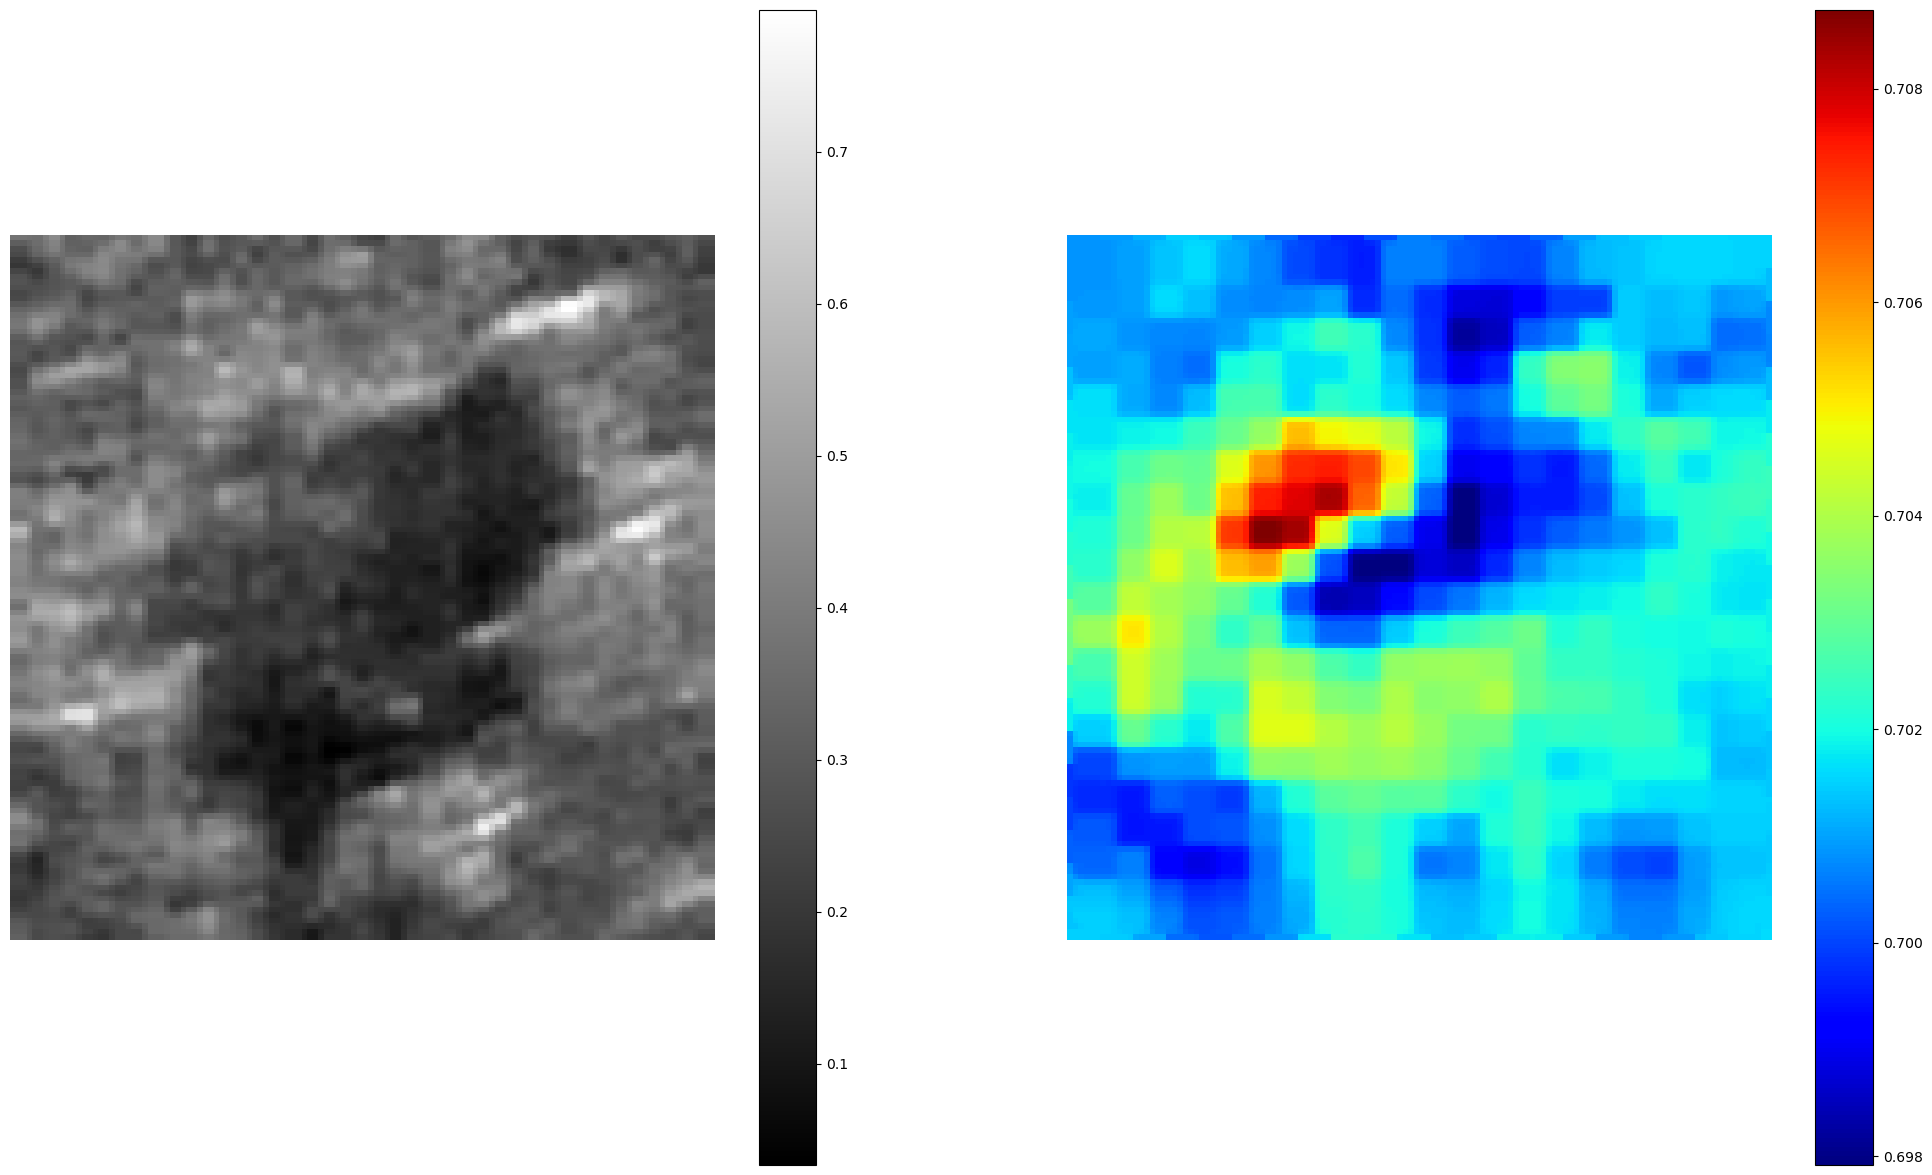

In [36]:
# Get the occlusion sensitivity map
# occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10, stride=12)
occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=10, overlap=0.5  # Change here
)

# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [depth_slice - 1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[0, label.argmax().item()][None]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)